# 0. 导入依赖库

In [67]:
%%capture --no-stderr
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [68]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("OPENAI_API_Base") # 中转key网址
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"



### 1. 定义工具

In [69]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your table."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\n"


-----------
### 2. 辅助函数：智能体节点


In [70]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 修正名称格式，移除空格并确保只包含合法字符
    name = name.replace(" ", "_").replace("-", "_")  # 确保符合正则表达式要求

    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }


### 3. 辅助函数：创建智能体



In [71]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, tool_message: str, custom_notice: str=""):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                "\n{custom_notice}\n"
                " You have access to the following tools: {tool_names}.\n{tool_message}\n\n",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符

        ]
    )

    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(tool_message=tool_message, custom_notice=custom_notice)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
      
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)



--------------
### 4. 定义 研究智能体及其节点



In [72]:
# 为 Agent 配置各自的大模型
research_llm = ChatOpenAI(model="gpt-4o-mini")
table_llm = ChatOpenAI(model="gpt-4o-mini")

In [73]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    tool_message=(
        "Before using the search engine, carefully think through and clarify the query."
        " Then, conduct a single search that addresses all aspects of the query in one go",
    ),
    custom_notice=(
        "Notice:\n"
        "Only gather and organize information. Do not generate code or give final conclusions, leave that for other assistants."
    ),
)



In [74]:
# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


------------------

### 5. 定义 表格生成器智能体及其节点



In [75]:
table_generator = create_agent(
    table_llm,  # 使用 table_llm 作为图表生成器智能体的语言模型
    [python_repl],  # 图表生成器智能体使用 Python REPL 工具
    tool_message="Let's do it step by step. First, create a statistical table and export it as a CSV file. Then, create a bar chart and export it as a PNG file.",  # 系统消息，指导智能体如何生成表格
    custom_notice="Notice:\n"
    "If you have completed all tasks, please just respond two words: FINAL ANSWER.",
)

In [76]:
# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "Table_Generator"
table_node = functools.partial(agent_node, agent=table_generator, name="Table_Generator")

### 6. 导入预构建的工具节点


In [77]:
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

------------------------

### 7. 建立智能体节点间通信 AgentState


In [78]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str


### 8. 定义工作流（状态图）
现在将所有内容组合在一起，定义多智能体的完整状态图。


In [79]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("Table_Generator", table_node)
workflow.add_node("call_tool", tool_node)


#### 定义路由函数
接下来定义边逻辑，以根据智能体的结果来决定下一步操作。


In [80]:
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息

    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"

    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"

    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"


#### 定义条件边逻辑


In [81]:
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "Table_Generator",  # 如果 router 返回 "continue"，则传递到 Table_Generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "Table_Generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "Table_Generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "Table_Generator": "Table_Generator",  # 如果 sender 是 Table_Generator，则返回给 Table_Generator
    },
)


In [82]:
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

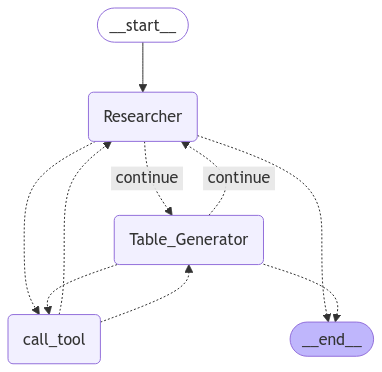

In [83]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")


### 9. 执行工作流

接下来我们将执行多智能体构建的工作流，最终生成一些统计图表。

In [84]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Obtain the GDP of the United States from 2000 to 2020, "
            "and then use python to create a table and bar chart."
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容


================================ Human Message =================================

Obtain the GDP of the United States from 2000 to 2020, and then use python to create a table and bar chart.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4204\4242814546.py:18: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_rPi0Ddl2Ox59OxewOTuqIjnI)
 Call ID: call_rPi0Ddl2Ox59OxewOTuqIjnI
  Args:
    query: United States GDP data from 2000 to 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.macrotrends.net/global-metrics/countries/USA/united-states/gdp-gross-domestic-product", "content": "| 2023 | $27,360.94B | $81,695 | 2.54% | | 2022 | $25,744.11B | $77,247 | 1.94% | | 2021 | $23,594.03B | $71,056 | 5.80% | | 2020 | $21,322.95B | $64,317 | -2.21% | | 2019 | $21,521.40B | $65,548 | 2.47% | | 2018 | $20,656.52B | $63,201 | 2.97% | | 2017 | $19,612.10B | $60,322 | 2.46% | | 2016 | $18,804.91B | $58,207 | 1.82% | | 2015 | $18,295.02B | $57,040 | 2.95% | | 2014 | $17,608.14B | $55,304 | 2.52% | | 2013 | $16,880.68B | $53,410 | 2.12% | | 2012 | $16,253.97B | $51,784 | 2.29% |

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4204\4242814546.py:18: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


================================== Ai Message ==================================
Name: Researcher

I gathered the GDP data for the United States from 2000 to 2020. Here are the figures extracted from the sources:

| Year | GDP (in Billion USD) |
|------|-----------------------|
| 2000 | 10,256.70             |
| 2001 | 10,582.50             |
| 2002 | 10,578.10             |
| 2003 | 10,917.00             |
| 2004 | 11,279.80             |
| 2005 | 11,683.80             |
| 2006 | 12,058.70             |
| 2007 | 12,546.50             |
| 2008 | 12,587.50             |
| 2009 | 14,418.70             |
| 2010 | 14,626.70             |
| 2011 | 15,599.73             |
| 2012 | 16,253.97             |
| 2013 | 16,880.68             |
| 2014 | 17,608.14             |
| 2015 | 18,295.02             |
| 2016 | 18,804.91             |
| 2017 | 19,612.10             |
| 2018 | 20,656.52             |
| 2019 | 21,521.40             |
| 2020 | 21,322.95             |

This data will be helpful f

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4204\4242814546.py:18: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


================================== Ai Message ==================================
Name: Table_Generator
Tool Calls:
  python_repl (call_Krm2E2YN5pqxntaWTC4QZYhw)
 Call ID: call_Krm2E2YN5pqxntaWTC4QZYhw
  Args:
    code: import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the GDP data
data = {
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'GDP (Billion USD)': [10256.70, 10582.50, 10578.10, 10917.00, 11279.80, 11683.80, 12058.70, 12546.50, 12587.50, 14418.70, 14626.70, 15599.73, 16253.97, 16880.68, 17608.14, 18295.02, 18804.91, 19612.10, 20656.52, 21521.40, 21322.95]
}

df = pd.DataFrame(data)

# Export the DataFrame to a CSV file
csv_file_path = 'US_GDP_2000_2020.csv'
df.to_csv(csv_file_path, index=False)

# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(df['Year'], df['GDP (Billion USD)'], color='skyblue')
plt.title('US GDP from 2000 to 2020')
plt.xlabel('Y

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4204\4242814546.py:18: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
